In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

import src.airbnb_NLP_helper as nlp

import nltk

from nltk.tokenize import sent_tokenize, regexp
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 

In [3]:
#import sys  
#sys.setdefaultencoding('utf8')

# Jeff's Recommendations

How to conduct NLP on non-general text?  For example, Airbnb reviews tend to have more “similarity” to each other than NYT articles, which tend have a lot of variety and breadth.  Thus, I am finding it hard to extract distinctive themes from the Airbnb reviews/descriptions.  
- Option 1: Min-max -> cut off words that are too common, or too rare

What clustering technique should I apply to Airbnb descriptions?  KMeans?  Heirarchal? 
How to group “words” together into themes?  For example, I would like the NLP to capture anything with the words = (Bus, light rail, terminal, station, etc) as “public transit”, instead of identifying each of those words as distinct.  Another example - group together “patio, garden, porch, balcony, deck” as “external features” 
- Option 1:  Try word2vec
- Option 2: Cluster by sentences!!!
- Option 3: Manually group words together (lemmatizer)

links for the nlp group on eomtions

http://wndomains.fbk.eu/wnaffect.html
wndomains.fbk.eu
WordNet Domains
WordNet Domains

[5:22]  
http://www.affective-sciences.org/files/7714/6719/1826/FiveLangAffectTerms_0.pdf

# Load listing information from file

In [4]:
open?

In [5]:
d=defaultdict()
d2=defaultdict()
with open('data/airbnb_scraping/scraped_listing_info_20170313_ALL.txt') as f:
    for i,line in enumerate(f):
        #print i
        if i==0:
            cur_prop_id = line.split(':')[1].strip()
        else:
            if ':' in line:
                key = line.split(':')[0].strip()
                val = line.split(':')[1].strip()
                if key=='prop_id':
                    d[cur_prop_id] = d2
                    cur_prop_id = val
                    d2=defaultdict()
                else:
                    #print key, val
                    d2[key] = val
            else: 
                print "Line break error on line ", i
                d2[key] = d2[key] + ' ' + line

Line break error on line  21325
Line break error on line  24932
Line break error on line  25504
Line break error on line  25506
Line break error on line  25507
Line break error on line  26668
Line break error on line  39561
Line break error on line  39563


## Convert dictionary to dataframe

In [6]:
df = pd.DataFrame.from_dict(d, orient='index', dtype=None)
df = df.reset_index()
df['url'] = df['index'].apply(lambda x: 'https://www.airbnb.com/rooms/{}'.format(x))

df['index'] = df['index'].astype(int)
df.set_index('index', inplace=True)
df.description = df.description.str.lower()
df.description = df.description.apply(lambda x: x.decode('utf-8').encode('ascii','ignore'))

In [7]:
df.shape

(1138, 54)

In [8]:
df.T

index,10015967,10043487,1009838,1012003,10152489,10152637,1018204,10209,1022135,10231701,...,975179,9772201,9781881,9813684,9814376,9823290,9846452,9878882,9958323,9999955
friend_count,0,0,0,0,0,0,NaN,0,1,0,...,0,0,0,4,0,0,0,1,0,0
Room type,Private room,Private room,Private room,Private room,Private room,Private room,NaN,Private room,Private room,Private room,...,Private room,Private room,Private room,Private room,Private room,Private room,Private room,Private room,Private room,Private room
response_rate_shown,None,1.0,1.0,1.0,None,1.0,NaN,1.0,None,1.0,...,1.0,1.0,0.0,1.0,0.899999976158,1.0,1.0,1.0,0.0,1.0
person_capacity,2,2,3,4,2,2,NaN,1,4,2,...,2,2,1,2,2,2,2,2,2,1
response_time_shown,None,370.0,1.0,3139.0,None,179.0,NaN,1616.0,None,6196.0,...,537.5,13579.5,86400.0,4229.5,382.0,2739.0,961.5,615.5,86400.0,2689.0
page,p3,p3,p3,p3,p3,p3,NaN,p3,p3,p3,...,p3,p3,p3,p3,p3,p3,p3,p3,p3,p3
Extra people,No Charge,No Charge,$10 / night after the first guest,$20 / night after 2 guests,No Charge,No Charge,NaN,NaN,$25 / night after the first guest,No Charge,...,$5 / night after the first guest,$5 / night after the first guest,NaN,No Charge,No Charge,No Charge,No Charge,$10 / night after the first guest,No Charge,NaN
Response time,NaN,within an hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,within a few hours,a few days or more,within a few hours,NaN,NaN,NaN,NaN,NaN,NaN
value_rating,None,9,9,10,10,10,NaN,9,9,9,...,10,8,None,10,9,10,None,10,10,10
description_language,en,en,en,en,en,en,NaN,en,en,en,...,en,en,en,en,en,en,en,en,en,en


In [9]:
numeric_cols = [
    'friend_count',
    #'Room type',
    'response_rate_shown',
    'person_capacity',
    'response_time_shown',
    'page',
    #'Extra people',
    #'Response time',
    'value_rating',
    #'description_language',
    #'title',
    'Bedrooms',
    'is_superhost',
    #'visible_review_count',
    'amenities',
    'cancel_policy',
    'instant_book_possible',
    'cleanliness_rating',
    'location_rating',
    'utc_offset',
    #'description',
    'price',
    'time_since_last_calendar_update',
    'Accommodates',
    'guest_satisfaction_overall',
    'Beds',
    'num_reviews',
    'picture_count',
    'Response rate',
    'listing_lat',
    #'Pet Owner',
    #'Property type',
    'Cancellation',
    'communication_rating',
    'Bathrooms',
    'checkin_rating',
    #'bed_type',
    'avg_rating',
    'listing_lng',
    'Cleaning Fee',
    #'room_type',
    'hosting_id',
    'saved_to_wishlist_count',
    'accuracy_rating',
    #'Check In',
    #'Bed type',
    #'Check Out',
    'Monthly Discount',
    'Weekly Discount',
    'Security Deposit',
    'Weekend Price',
    'Self check-in',
    #'details',
    #'url',
]

In [10]:
# temp_df = df.copy()
# for col in numeric_cols:
#     print col
#     temp_df[col] = pd.to_numeric(temp_df[col])

In [11]:
listing_info_df = df.convert_objects(convert_numeric=True)

/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


## Text cleaning

In [12]:
listing_info_df.description = listing_info_df.description.str.lower()

In [13]:
listing_info_df.description.replace('queen anne', 'queenanne', inplace=True)

In [14]:
listing_info_df[listing_info_df.description.str.contains('advent')]['description']

index
11775115    welcome to north capitol hill  this is a weste...
12111798    this 12th floor unit is located in a secured b...
12520642    my place is close to the airport, the city cen...
12749302    our home is close to public transit, grocery s...
12813759    1928 tutor home, w/original coved ceilings, ma...
12891796    my place is close to seattle art museum. youll...
12987399    my place is close to seattle pacific universit...
13021356    youll love my place because it has been fully ...
13042011    my place is close to sea-tac airport, restaura...
13081345    my place in the mt. baker neighborhood is clos...
13082137    my place is close to jewelbox northgatemall. m...
13140008    my place is walking distance to link light rai...
13163323    my place is close to university of washington ...
13175242    my place is close to a dog park, shorty's, sta...
13210353    my place is close to public transport, the air...
13212923    my place is close to public transport, the air...
13

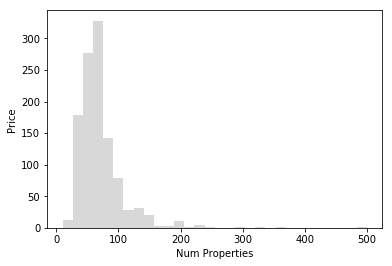

In [15]:
listing_info_df['price'].hist(bins=30, alpha=0.3, color='gray')
plt.xlabel('Num Properties')
plt.ylabel('Price')
plt.grid(False)
plt.show()

## Text Analysis

In [16]:
import string
punctuation_ = set(string.punctuation)

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [18]:
sb_stemmer = SnowballStemmer("english")
p_stemmer = PorterStemmer()

In [19]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [sb_stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [20]:
import re
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in listing_info_df.description:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [21]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [22]:
airbnb_stopwords = [
'and', 'the', 'to', 'a', 'in', 'of', 'with', 'is',  'on', 'you', 'this','our', 'has', 'are', 'for','your', 'out', 'there', 'will',
'can', 'be',  'but', 'its', 're','which','here', 'or',  'we', 'it',  'an','from','by','my', 'have', 'at', 'as', 'just',
'room','bedroom','bed', 'home','house',
'seattle'
]

In [23]:
tf = CountVectorizer(stop_words=airbnb_stopwords, 
                     max_features=10000, ngram_range=(2,2),
                     #min_df=0.02, max_df=0.98,
                     #tokenizer=tokenize_and_stem)
                    )

tf_matrix = tf.fit_transform(listing_info_df.description)
tf_vocab= np.array(tf.get_feature_names())
tf_matrix_sum = np.sum(tf_matrix.toarray(),axis=0)
sorted_ind = np.argsort(tf_matrix_sum)[::-1]

N = 100
print "Top word frequency for all Seattle properties"
print "---------------------------------------------"
print ', '.join([ "'{}'".format(word) for word in  tf_vocab[sorted_ind[:N]]])

print tf_matrix_sum[sorted_ind[:N]]

Top word frequency for all Seattle properties
---------------------------------------------
'solo adventurers', 'business travelers', 'couples solo', 'place good', 'adventurers business', 'light rail', 'good couples', 'youll love', 'place close', 'place because', 'walking distance', 'love place', 'capitol hill', 'private bathroom', 'easy access', 'minute walk', 'private bath', 'bus lines', 'street parking', 'space needle', 'quiet neighborhood', 'lake union', 'pike place', 'queen anne', 'alki beach', 'queen size', 'minutes downtown', 'within walking', 'seatac airport', 'bus ride', 'drive downtown', 'restaurants bars', 'coffee shops', 'minutes away', 'bus line', 'blocks away', 'great location', 'rail station', 'minute drive', '15 minutes', '10 minutes', 'shared bathroom', 'lake washington', 'place market', '15 minute', 'access downtown', 'university washington', 'shops restaurants', 'private entrance', 'less than', 'kitchen living', 'short walk', 'puget sound', 'does not', 'grocery store

# Analyzing Airbnb Descriptions - Term Frequency

In [24]:
nlp.get_top_term_frequency(tf=tf, df=listing_info_df, column='description', 
                           by='price', lower_lim=0, upper_lim=9999, 
                           num_words=25)

Number of properties: 1126
Top term frequency based on price, 0 > price > 9999
---------------------------------------------
              solo adventurers,  141, 12.52%
            business travelers,  128, 11.37%
                  couples solo,  121, 10.75%
                    place good,  119, 10.57%
          adventurers business,  118, 10.48%
                    light rail,  114, 10.12%
                  good couples,  105, 9.33%
                    youll love,  105, 9.33%
                   place close,  104, 9.24%
                 place because,   96, 8.53%
              walking distance,   96, 8.53%
                    love place,   96, 8.53%
                  capitol hill,   89, 7.90%
              private bathroom,   86, 7.64%
                   easy access,   77, 6.84%
                   minute walk,   67, 5.95%
                  private bath,   64, 5.68%
                     bus lines,   62, 5.51%
                street parking,   58, 5.15%
                  space needle,  

In [25]:
nlp.get_top_term_frequency(tf=tf, df=listing_info_df, column='description', 
                           by='price', lower_lim=0, upper_lim=50, 
                           num_words=25)

Number of properties: 308
Top term frequency based on price, 0 > price > 50
---------------------------------------------
                   place close,   40, 12.99%
              solo adventurers,   37, 12.01%
                    light rail,   35, 11.36%
                    place good,   33, 10.71%
          adventurers business,   31, 10.06%
            business travelers,   31, 10.06%
                  couples solo,   28, 9.09%
                  good couples,   27, 8.77%
                    youll love,   27, 8.77%
                    love place,   26, 8.44%
                 place because,   25, 8.12%
                drive downtown,   24, 7.79%
                     live site,   21, 6.82%
            quiet neighborhood,   21, 6.82%
                     host does,   21, 6.82%
                      does not,   21, 6.82%
                      not live,   21, 6.82%
              walking distance,   20, 6.49%
              private bathroom,   18, 5.84%
                    15 minutes,   18

In [26]:
nlp.get_top_term_frequency(tf=tf, df=listing_info_df, column='description', 
                           by='price', lower_lim=50, upper_lim=75, 
                           num_words=25)

Number of properties: 423
Top term frequency based on price, 50 > price > 75
---------------------------------------------
              solo adventurers,   55, 13.00%
            business travelers,   51, 12.06%
                  couples solo,   51, 12.06%
          adventurers business,   47, 11.11%
                    place good,   45, 10.64%
                    youll love,   44, 10.40%
                  good couples,   44, 10.40%
                    light rail,   43, 10.17%
                   easy access,   40, 9.46%
              private bathroom,   40, 9.46%
              walking distance,   37, 8.75%
                 place because,   37, 8.75%
                    love place,   37, 8.75%
                  capitol hill,   36, 8.51%
                     bus lines,   32, 7.57%
                street parking,   29, 6.86%
                   place close,   29, 6.86%
                   minute walk,   22, 5.20%
              restaurants bars,   22, 5.20%
                  private bath,  

In [27]:
nlp.get_top_term_frequency(tf=tf, df=listing_info_df, column='description', 
                           by='price', lower_lim=75, upper_lim=100, 
                           num_words=25)

Number of properties: 249
Top term frequency based on price, 75 > price > 100
---------------------------------------------
                  capitol hill,   32, 12.85%
            business travelers,   30, 12.05%
              solo adventurers,   29, 11.65%
                    light rail,   27, 10.84%
                    place good,   26, 10.44%
                  couples solo,   24, 9.64%
          adventurers business,   23, 9.24%
              walking distance,   21, 8.43%
                  private bath,   21, 8.43%
                  good couples,   20, 8.03%
              private bathroom,   20, 8.03%
                    youll love,   18, 7.23%
                street parking,   18, 7.23%
                   minute walk,   18, 7.23%
            quiet neighborhood,   18, 7.23%
                    love place,   17, 6.83%
                 place because,   17, 6.83%
                  space needle,   17, 6.83%
                   easy access,   16, 6.43%
                   place close,   1

In [28]:
nlp.get_top_term_frequency(tf=tf, df=listing_info_df, column='description', 
                           by='price', lower_lim=100, upper_lim=9999, 
                           num_words=25)

Number of properties: 146
Top term frequency based on price, 100 > price > 9999
---------------------------------------------
                   place close,   20, 13.70%
              solo adventurers,   20, 13.70%
                  couples solo,   18, 12.33%
                    lake union,   18, 12.33%
              walking distance,   18, 12.33%
          adventurers business,   17, 11.64%
                 place because,   17, 11.64%
                    queen anne,   16, 10.96%
                    love place,   16, 10.96%
                    youll love,   16, 10.96%
            business travelers,   16, 10.96%
                  space needle,   15, 10.27%
                   minute walk,   15, 10.27%
                    place good,   15, 10.27%
                  good couples,   14, 9.59%
                  capitol hill,   13, 8.90%
                  private bath,   11, 7.53%
                    pike place,   11, 7.53%
                  minutes away,   10, 6.85%
                    ligh

# Analyzing Airbnb Descriptions - tfidf

In [29]:
### 
tfidf = TfidfVectorizer(stop_words=airbnb_stopwords, ngram_range=(2,2), 
                        max_features=10000,
                        min_df=0.02, max_df=0.98,
                        tokenizer=tokenize_and_stem
                        )

tfidf_matrix = tfidf.fit_transform(listing_info_df.description)
tfidf_vocab = np.array(tfidf.get_feature_names())

In [30]:
nlp.get_top_tfidf_words(df=listing_info_df, column='price',
                    tfidf_matrix=tfidf_matrix, tfidf_vocab=tfidf_vocab, 
                    start_prop=0, end_prop=len(listing_info_df), num_words=25)

Top 25 tfidf words for properties in range 0-1138 by price
----------------------------------------------------
                 full bathroom: 0.701
                  kitchen live: 0.693
                    queen size: 0.687
                share bathroom: 0.673
                 central locat: 0.647
                   great locat: 0.630
                 conveni locat: 0.626
                    short walk: 0.619
                   puget sound: 0.613
                   privat bath: 0.612
                privat entranc: 0.611
               privat bathroom: 0.606
               lake washington: 0.592
                   west seattl: 0.591
              airport downtown: 0.589
                    minut away: 0.580
                    alki beach: 0.578
                     less than: 0.565
                minut downtown: 0.562
                     queen ann: 0.559
                    minut walk: 0.558
                   easi access: 0.551
                     seattl 's: 0.551
            qu

In [31]:
nlp.get_top_tfidf_words(df=listing_info_df,column='price',
                    tfidf_matrix=tfidf_matrix, tfidf_vocab=tfidf_vocab, 
                    start_prop=0, end_prop=100, num_words=20)

Top 20 tfidf words for properties in range 0-100 by price
----------------------------------------------------
                    hous locat: 1.000
                     less than: 0.960
                 full bathroom: 0.883
                   restaur bar: 0.850
                  kitchen live: 0.833
               privat bathroom: 0.739
                    alki beach: 0.696
                    queen size: 0.691
                    minut away: 0.671
                    lake union: 0.667
                    minut walk: 0.653
                    short walk: 0.649
               access downtown: 0.643
                   puget sound: 0.638
            quiet neighborhood: 0.633
                     queen ann: 0.618
                 central locat: 0.618
                   within walk: 0.611
                privat entranc: 0.607
                   great locat: 0.603


In [32]:
nlp.get_top_tfidf_words(df=listing_info_df,column='price',
                    tfidf_matrix=tfidf_matrix, tfidf_vocab=tfidf_vocab, 
                    start_prop=100, end_prop=250, num_words=20)

Top 20 tfidf words for properties in range 100-250 by price
----------------------------------------------------
                 central locat: 1.000
                    short walk: 1.000
                privat entranc: 0.849
                      bus stop: 0.831
                  north seattl: 0.780
                     seattl 's: 0.764
                   great locat: 0.748
                    minut away: 0.736
                   puget sound: 0.702
                    queen size: 0.694
            quiet neighborhood: 0.680
                 full bathroom: 0.671
                share bathroom: 0.649
                    minut walk: 0.627
                     queen ann: 0.623
                   privat bath: 0.620
                  shop restaur: 0.607
                seatac airport: 0.592
                   space needl: 0.591
                    alki beach: 0.585


In [33]:
nlp.get_top_tfidf_words(df=listing_info_df,column='price',
                    tfidf_matrix=tfidf_matrix, tfidf_vocab=tfidf_vocab, 
                    start_prop=250, end_prop=500, num_words=20)

Top 20 tfidf words for properties in range 250-500 by price
----------------------------------------------------
                  kitchen live: 0.706
                    queen size: 0.703
               privat bathroom: 0.677
                share bathroom: 0.675
                    minut away: 0.655
                 conveni locat: 0.645
              airport downtown: 0.642
                 full bathroom: 0.628
               lake washington: 0.623
                     less than: 0.613
                privat entranc: 0.612
                    short walk: 0.611
                 central locat: 0.611
                minut downtown: 0.585
                     seattl 's: 0.579
                   puget sound: 0.577
                 seattl center: 0.572
                   easi access: 0.565
                    minut walk: 0.562
                 great restaur: 0.556


In [34]:
nlp.get_top_tfidf_words(df=listing_info_df,column='price',
                    tfidf_matrix=tfidf_matrix, tfidf_vocab=tfidf_vocab, 
                    start_prop=900, end_prop=1200, num_words=20)

Top 20 tfidf words for properties in range 900-1200 by price
----------------------------------------------------
                 full bathroom: 0.767
                    short walk: 0.727
                 central locat: 0.713
                   privat bath: 0.699
                  kitchen live: 0.692
                    queen size: 0.662
                     few block: 0.648
                share bathroom: 0.639
                    alki beach: 0.638
                 conveni locat: 0.636
               privat bathroom: 0.634
                   great locat: 0.608
                   west seattl: 0.604
              airport downtown: 0.595
                    block away: 0.587
                minut downtown: 0.582
                privat entranc: 0.575
                     queen ann: 0.569
                   restaur bar: 0.551
              public transport: 0.550


# Tokenize by sentence

In [35]:
listing_info_df.iloc[1]['description']

'private bedroom and bathroom available in a 1500 sq foot townhouse. this room is located on the first floor, which provides a lot of privacy. it contains a full bed. the bathroom has a shower.'

In [36]:
sent_tokenize(listing_info_df.iloc[1]['description'])

['private bedroom and bathroom available in a 1500 sq foot townhouse.',
 'this room is located on the first floor, which provides a lot of privacy.',
 'it contains a full bed.',
 'the bathroom has a shower.']

In [37]:
sentences=[]
for desc in listing_info_df.description:
    for sentence in sent_tokenize(desc):
        sentences.append(sentence)

In [38]:
len(sentences)

3834

In [39]:
sent_tfidf = TfidfVectorizer(stop_words=airbnb_stopwords)
sent_tfidf_matrix = sent_tfidf.fit_transform(sentences)

In [40]:
sent_vocab = np.array( sent_tfidf.get_feature_names())

In [41]:
sent_vocab

array([u'00', u'000', u'10', ..., u'zippy', u'zone', u'zoo'], 
      dtype='<U21')

In [42]:
sent_tfidf_matrix.toarray().shape

(3834, 3472)

In [43]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans

In [44]:
kmeans_sent_model = KMeans(n_clusters=20)
kmeans_sent_model.fit(sent_tfidf_matrix.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [45]:
# Take top50 properties by price and compare tfidf to bot50 properties to see which terms stand out

In [46]:
def get_top_N_words_per_kmeans_cluster(cluster_centers, vocab, n_words=10):

    topN_tfidf_list = []
    topN_words_list = []
    for cluster in cluster_centers:
        sorted_ind = np.argsort(cluster)[::-1][:n_words]
        topN_words_list.append(vocab[sorted_ind])
        topN_tfidf_list.append(cluster[sorted_ind])
        
    return topN_words_list


In [47]:
top_words_per_cluster = get_top_N_words_per_kmeans_cluster(kmeans_sent_model.cluster_centers_, sent_vocab, n_words=10)
for i,cluster in enumerate(top_words_per_cluster):
    print i, cluster

0 [u'close' u'restaurants' u'place' u'parks' u'walking' u'distance' u'beach'
 u'downtown' u'bars' u'shops']
1 [u'solo' u'adventurers' u'good' u'couples' u'business' u'travelers'
 u'place' u'families' u'furry' u'kids']
2 [u'welcome' u'queen' u'one' u'view' u'available' u'coffee' u'size' u'also'
 u'comfortable' u'located']
3 [u'shared' u'bathroom' u'airbnb' u'guest' u'bath' u'private' u'located'
 u'shower' u'district' u'university']
4 [u'location' u'great' u'west' u'convenient' u'downtown' u'15min' u'perfect'
 u'proximity' u'visit' u'city']
5 [u'quiet' u'neighborhood' u'clean' u'very' u'comfortable' u'located'
 u'north' u'quaint' u'safe' u'street']
6 [u'private' u'bath' u'bathroom' u'comfortable' u'queen' u'spacious'
 u'clean' u'entrance' u'floor' u'own']
7 [u'easy' u'access' u'downtown' u'bus' u'airport' u'rail' u'transit' u'hwy'
 u'transportation' u'99']
8 [u'because' u'love' u'youll' u'place' u'location' u'comfy' u'neighborhood'
 u'coziness' u'people' u'ambiance']
9 [u'all' u'that' u'

In [48]:
np.bincount(kmeans_sent_model.labels_)

array([ 268,  142, 1395,  107,   63,  157,  260,   90,  100,  199,   28,
        147,   54,  126,   92,  128,  103,  166,   94,  115])

# Heirarchical Clustering

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

In [50]:
dist = 1 - cosine_similarity(tfidf_matrix.toarray())

In [51]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

In [52]:
desc_short = listing_info_df.description.apply(lambda x: x[:50])

In [53]:
# fig, ax = plt.subplots(figsize=(15, 20)) # set size
# ax = dendrogram(linkage_matrix, orientation="right", labels=desc_short);
# plt.tick_params(\
#     axis= 'x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')

# plt.tight_layout() #show plot with tight layout
# plt.show()
# #uncomment below to save figure
# #plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [ ]:
# from scipy.spatial.distance import pdist
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import linkage

In [ ]:
#tfidf_similarity = pdist(tfidf_matrix.toarray(), metric='cosine')

In [ ]:
#tfidf_similarity_matrix = squareform(tfidf_similarity)

In [ ]:
#heir_cluster = linkage(tfidf_similarity_matrix)

# Topic Modeling

### SVD

In [54]:
U,Sigma,VT = np.linalg.svd(tfidf_matrix.toarray())

In [55]:
Sigma[:50]

array([ 9.32566645,  7.14693981,  5.74374941,  5.56097271,  5.33585534,
        5.2872998 ,  5.13242806,  5.0896711 ,  4.89337925,  4.79697451,
        4.73505161,  4.48284619,  4.41179022,  4.32816617,  4.24682235,
        4.19347968,  4.15353824,  4.05346411,  4.00279632,  3.93348326,
        3.78703314,  3.7214513 ,  3.69245508,  3.63535109,  3.61190388,
        3.60476081,  3.55471942,  3.52877723,  3.46428541,  3.41282864,
        3.35900854,  3.3494293 ,  3.32704024,  3.31598872,  3.22042729,
        3.19874779,  3.19294383,  3.16351123,  3.11163112,  3.08542225,
        3.0504457 ,  2.96990859,  2.92278874,  2.89423185,  2.78704314,
        2.73973518,  2.68213128,  2.64982953,  2.57848195,  2.52959896])

## Problems with SVD for topic analysis

**Recall:** $M = U S V^T$

1. Values in $U$ and $V^T$ can be negative, which is weird and hard to interpret. For example, suppose a latent feature is the genre 'Science fiction'. This feature can be positive (makes sense), zero (makes sense), or negative (what does that mean?).

2. The number of columns in $U$ can differ from the number of rows in $V^T$. I.e. The number of latent features differs in $U$ and $V^T$, which is weird.

3. SVD forces us to fill in missing values, then SVD models those missing values, which is bad.

How can we avoid these?

### NMF Factorization

In [56]:
from sklearn.decomposition import NMF

In [95]:
tf_NMF = CountVectorizer(stop_words=airbnb_stopwords, max_features=2000, ngram_range=(2,2), min_df=2)
tf_NMF_matrix = tf_NMF.fit_transform(listing_info_df.description)
tf_NMF_vocab= np.array(tf_NMF.get_feature_names())

In [96]:
nmf = NMF(n_components=20)
nmf.fit(tf_NMF_matrix.toarray())

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)

In [97]:
W = nmf.transform(tf_NMF_matrix.toarray())
H = nmf.components_
print 'RSS = %.2f' % nmf.reconstruction_err_

RSS = 94.97


In [98]:
W.shape, H.shape

((1138, 20), (20, 2000))

In [99]:
W = pd.DataFrame(W,index=listing_info_df.description)
H = pd.DataFrame(H,columns=tf_NMF_vocab)

In [100]:
#W.head()

In [101]:
for row in xrange(H.shape[0]):
    print row, ', '.join(list(H.iloc[row].sort_values(ascending=False).index[:8]))
    #print (list(H.iloc[row].sort_values(ascending=False)[:10]))

0 solo adventurers, couples solo, adventurers business, business travelers, good couples, place good, place close, travelers families
1 coffee shops, blocks away, 10 minutes, few blocks, drive downtown, university district, best coffee, does not
2 minute walk, 15 minute, minute drive, 20 minute, 10 minute, drive downtown, walk downtown, downtown 20
3 light rail, rail station, seward park, downtown light, available private, walk seward, park very, convenient airport
4 private bathroom, street parking, queen size, kitchen living, free street, shared kitchen, great restaurants, memory foam
5 easy access, hwy 99, expected quality, edmonds lynnwood, aurora hwy, shoreline unique, echo lake, unique contemporary
6 love place, place because, youll love, place close, place good, because location, because comfy, good solo
7 lake union, great location, shops restaurants, drive downtown, close proximity, union close, location visit, wallingford cute
8 capitol hill, light rail, downtown capitol, hea

**What are the top properties for each topic above?**

In [73]:
for topic in xrange(H.shape[0]):
    print topic,'====\n', '\n'.join(list(W.iloc[:,topic].sort_values(ascending=False).index[:3]))
    #print (list(H.iloc[row].sort_values(ascending=False)[:10]))

0 ====
my place is close to seattle pacific university, discovery park, downtown seattle, ballard, freemont, whole foods, interbay golf course, elliot bay trail. youll love my place because of the convenience, amenities, and central location.  my place is good for couples and solo adventurers.. my place is good for couples, solo adventurers, and business travelers.
my house is convenient (15-20 mins) to the city, but away from the hustle and bustle of downtown.   an easy location, 10 minutes to university of washington, three blocks west of lake washington, & bike trails [bikes available]. walkable neighborhood with all the services within a few blocks. the bedroom is downstairs and your privacy is respected.  my place is good for couples, solo adventurers, business travelers and families. studio also available for rent.
1928 tutor home, w/original coved ceilings, mahogany trim, fireplace, & oak floors.  there is a suite of 2 bedrooms available (1 queen, 1 twin) on the 1st first floor,

**What are the top topics for the top 10 priced properties**

In [83]:
price_top10_ind = list(listing_info_df.reset_index().sort_values(by='price', ascending=False)[['price', 'description']][:10].index)

In [84]:
topic_weights_top10 = np.mean(W.iloc[price_top10_ind], axis=0)
sorted_ind_top10 = np.argsort(topic_weights_top10, axis=0)[::-1]

In [86]:
weight_cumsum=0
for ind in sorted_ind_top10:
    weight_cumsum +=topic_weights_top10[ind]
    print '{:>2}, {:.03f}, {:.03f}, {}'.format(ind, topic_weights_top10[ind],weight_cumsum, 
                              ', '.join(list(H.iloc[ind].sort_values(ascending=False).index[:5])))
    #print '{:11s}{}'.format('',(list(H.iloc[ind].sort_values(ascending=False)[:5])))

13, 0.121, 0.121, place, because, love, place because, love place
14, 0.112, 0.233, space, queen, street, needle, space needle
11, 0.064, 0.298, lake, great, union, lake union, close
 0, 0.063, 0.360, travelers, solo, couples, business, adventurers
18, 0.059, 0.419, minutes, away, minutes away, minutes downtown, 15 minutes
 3, 0.058, 0.476, private, bathroom, bath, private bathroom, private bath
 7, 0.055, 0.532, kitchen, shared, bathroom, full, living
 5, 0.038, 0.570, hill, capitol, capitol hill, downtown, located
 1, 0.037, 0.606, downtown, airport, mins, 15, located
 8, 0.022, 0.629, access, easy, easy access, access downtown, downtown
 9, 0.011, 0.640, neighborhood, quiet, quiet neighborhood, close, city
 2, 0.009, 0.649, available, university, parking, coffee, blocks
17, 0.006, 0.655, clean, university, uw, living, downtown
19, 0.004, 0.659, not, shared, guest, host, airbnb
16, 0.004, 0.663, min, 10, 10 min, walk, 15
15, 0.002, 0.666, located, lake, area, centrally, hwy
10, 0.001

**What are the top topics for properties with price > 100?**

In [87]:
price_GT100_ind = list(listing_info_df.reset_index()[listing_info_df.reset_index().price>100].index)

In [88]:
#W.iloc[price_GT100_ind].head()

In [89]:
topic_weights_GT100 = np.mean(W.iloc[price_GT100_ind], axis=0)
sorted_ind_GT100 = np.argsort(topic_weights_GT100, axis=0)[::-1]

In [90]:
weight_cumsum=0
for ind in sorted_ind_GT100:
    weight_cumsum +=topic_weights_GT100[ind]
    print '{:>2}, {:.03f}, {:.03f}, {}'.format(ind, topic_weights_GT100[ind],weight_cumsum, 
                              ', '.join(list(H.iloc[ind].sort_values(ascending=False).index[:5])))
    #print '{:11s}{}'.format('',(list(H.iloc[ind].sort_values(ascending=False)[:5])))

14, 0.089, 0.089, space, queen, street, needle, space needle
 3, 0.087, 0.175, private, bathroom, bath, private bathroom, private bath
13, 0.086, 0.261, place, because, love, place because, love place
11, 0.064, 0.325, lake, great, union, lake union, close
 6, 0.063, 0.388, walk, minute, minute walk, 15 minute, minute drive
 5, 0.051, 0.440, hill, capitol, capitol hill, downtown, located
18, 0.050, 0.490, minutes, away, minutes away, minutes downtown, 15 minutes
10, 0.049, 0.538, walking, distance, walking distance, restaurants, within
 0, 0.045, 0.584, travelers, solo, couples, business, adventurers
 9, 0.044, 0.628, neighborhood, quiet, quiet neighborhood, close, city
 1, 0.040, 0.668, downtown, airport, mins, 15, located
 7, 0.036, 0.704, kitchen, shared, bathroom, full, living
12, 0.031, 0.735, bus, lines, bus lines, downtown, ride
16, 0.025, 0.760, min, 10, 10 min, walk, 15
 4, 0.025, 0.785, light, rail, light rail, station, rail station
 8, 0.021, 0.806, access, easy, easy access

**What are the top topics for properties with 50 < price < 100?**

In [91]:
price_GT050_LT100_ind = list(listing_info_df.reset_index()[(listing_info_df.reset_index().price>=50) & (listing_info_df.reset_index().price<=100)].index)

In [92]:
#W.iloc[price_GT050_LT100_ind].head()

In [93]:
topic_weights_GT050_LT100 = np.mean(W.iloc[price_GT050_LT100_ind], axis=0)
sorted_ind_GT050_LT100 = np.argsort(topic_weights_GT050_LT100, axis=0)[::-1]

In [94]:
weight_cumsum=0
for ind in sorted_ind_GT050_LT100:
    weight_cumsum+=topic_weights_GT050_LT100[ind]
    print '{:>2}, {:.03f}, {:.03f}, {}'.format(ind, topic_weights_GT050_LT100[ind], weight_cumsum,
                              ', '.join(list(H.iloc[ind].sort_values(ascending=False).index[:5])))
    #print '{:11s}{}'.format('',(list(H.iloc[ind].sort_values(ascending=False)[:5])))

 3, 0.100, 0.100, private, bathroom, bath, private bathroom, private bath
12, 0.072, 0.172, bus, lines, bus lines, downtown, ride
 9, 0.066, 0.238, neighborhood, quiet, quiet neighborhood, close, city
13, 0.064, 0.302, place, because, love, place because, love place
10, 0.059, 0.362, walking, distance, walking distance, restaurants, within
 7, 0.058, 0.420, kitchen, shared, bathroom, full, living
14, 0.057, 0.477, space, queen, street, needle, space needle
 5, 0.052, 0.529, hill, capitol, capitol hill, downtown, located
 8, 0.049, 0.578, access, easy, easy access, access downtown, downtown
 6, 0.046, 0.624, walk, minute, minute walk, 15 minute, minute drive
 1, 0.045, 0.669, downtown, airport, mins, 15, located
 4, 0.043, 0.713, light, rail, light rail, station, rail station
 0, 0.040, 0.752, travelers, solo, couples, business, adventurers
11, 0.036, 0.788, lake, great, union, lake union, close
18, 0.034, 0.822, minutes, away, minutes away, minutes downtown, 15 minutes
16, 0.030, 0.852

**What are the top topics for properties with price < 50?**

In [102]:
price_LT050_ind = list(listing_info_df.reset_index()[listing_info_df.reset_index().price<50].index)

In [106]:
#W.iloc[price_LT050_ind].head()

In [104]:
topic_weights_LT050 = np.mean(W.iloc[price_LT050_ind], axis=0)
sorted_ind_LT050 = np.argsort(np.mean(W.iloc[price_LT050_ind], axis=0))[::-1]

In [105]:
for ind in sorted_ind_LT050:
    weight_cumsum+=sorted_ind_LT050[ind]
    print '{:>2}, {:.03f}, {:.03f}, {}'.format(ind, topic_weights_LT050[ind], weight_cumsum,
                              ', '.join(list(H.iloc[ind].sort_values(ascending=False).index[:5])))
    #print '{:11s}{}'.format('',(list(H.iloc[ind].sort_values(ascending=False)[:5])))

 0, 0.042, 5.936, solo adventurers, couples solo, adventurers business, business travelers, good couples
 1, 0.042, 16.936, coffee shops, blocks away, 10 minutes, few blocks, drive downtown
 3, 0.037, 24.936, light rail, rail station, seward park, downtown light, available private
14, 0.036, 31.936, easy access, minutes away, access downtown, seatac airport, airport downtown
13, 0.030, 46.936, walking distance, within walking, private bath, restaurants bars, quiet neighborhood
 7, 0.030, 65.936, lake union, great location, shops restaurants, drive downtown, close proximity
15, 0.024, 78.936, bus lines, short walk, university washington, walk bus, steps away
16, 0.024, 92.936, good solo, grocery stores, people place, solo adventurers, because coziness
18, 0.024, 93.936, quiet neighborhood, discovery park, city center, close city, tucked away
 6, 0.022, 105.936, love place, place because, youll love, place close, place good
 9, 0.021, 114.936, fully stocked, stocked kitchen, go please, c

# LDA (Latent Dirichlet Allocation)

In [ ]:
import lda

In [ ]:
listing_info_df.description.shape

In [ ]:
X = lda.datasets.load_reuters()
vocab = lda.datasets.load_reuters_vocab()

In [ ]:
lda_model = lda.LDA(n_topics=20, n_iter=1000)
lda_model.fit(X)

In [ ]:
#vocab = tfidf.get_feature_names()

In [ ]:
topic_word = lda_model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
